In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    precision_score, recall_score, precision_recall_curve, 
    auc, confusion_matrix, ConfusionMatrixDisplay
)
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE, KMeansSMOTE
from imblearn.combine import SMOTEENN, SMOTETomek
from sklearn.cluster import MiniBatchKMeans

In [2]:
# Load and split data
data = pd.read_csv('../data/processed/fraud.csv')
X = data.drop(columns=['FraudFound_P'])
y = data['FraudFound_P'].astype(int)

X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.25, random_state=42, stratify=y_train_full
)

print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")

Train: 9252, Val: 3084, Test: 3084


In [3]:
# Define resampling methods
kmeans = MiniBatchKMeans(n_clusters=5, random_state=42)

resamplers = {
    "SMOTE": SMOTE(random_state=42),
    "SMOTEENN": SMOTEENN(random_state=42),
    "SMOTETomek": SMOTETomek(random_state=42),
    "KMeansSMOTE": KMeansSMOTE(
        random_state=42, kmeans_estimator=kmeans, cluster_balance_threshold=0.01
    )
}

In [4]:
# Define class distribution helper
def plot_class_distribution(y_before, y_after, title):
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    sns.countplot(x=y_before, ax=axes[0])
    axes[0].set_title(f"Before {title}")
    sns.countplot(x=y_after, ax=axes[1])
    axes[1].set_title(f"After {title}")
    for ax in axes:
        ax.set_xlabel('Class')
        ax.set_ylabel('Count')
    plt.tight_layout()
    plt.show()

In [5]:
# Define evaluation helper
def evaluate_pipeline(name, pipeline, X_train, y_train, X_val, y_val):
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_val)
    y_prob = pipeline.predict_proba(X_val)[:, 1]

    precision_curve, recall_curve, _ = precision_recall_curve(y_val, y_prob)

    return {
        "PR-AUC": auc(recall_curve, precision_curve),
        "Precision": precision_score(y_val, y_pred),
        "Recall": recall_score(y_val, y_pred)
    }

SMOTE distribution:
 FraudFound_P
0    8698
1    8698
Name: count, dtype: int64 



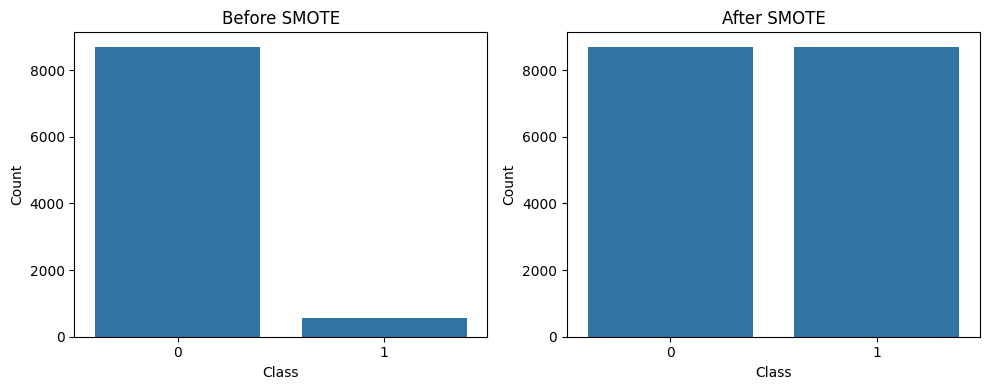

SMOTEENN distribution:
 FraudFound_P
1    7680
0    4561
Name: count, dtype: int64 



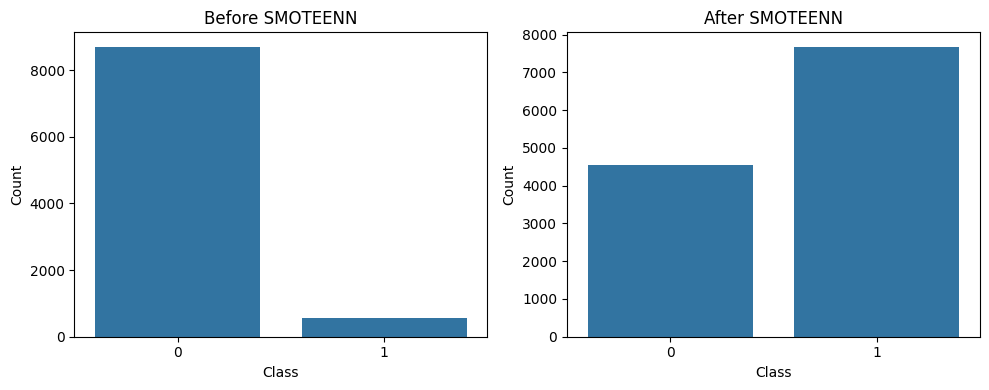

SMOTETomek distribution:
 FraudFound_P
0    8560
1    8560
Name: count, dtype: int64 



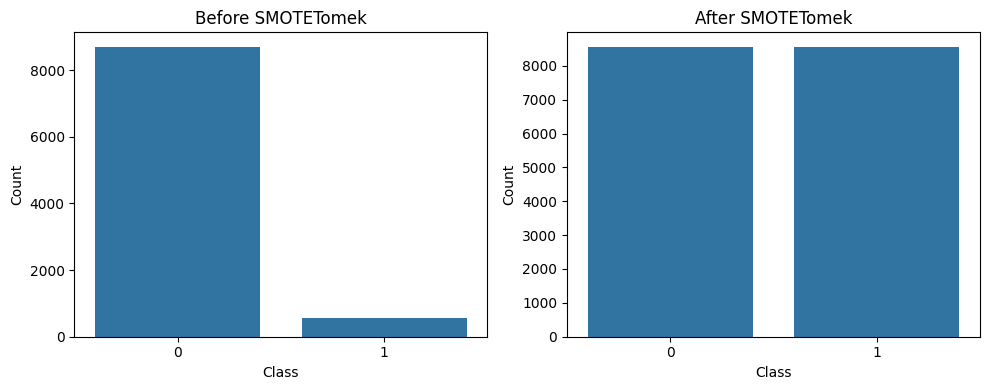

KMeansSMOTE distribution:
 FraudFound_P
1    8701
0    8698
Name: count, dtype: int64 



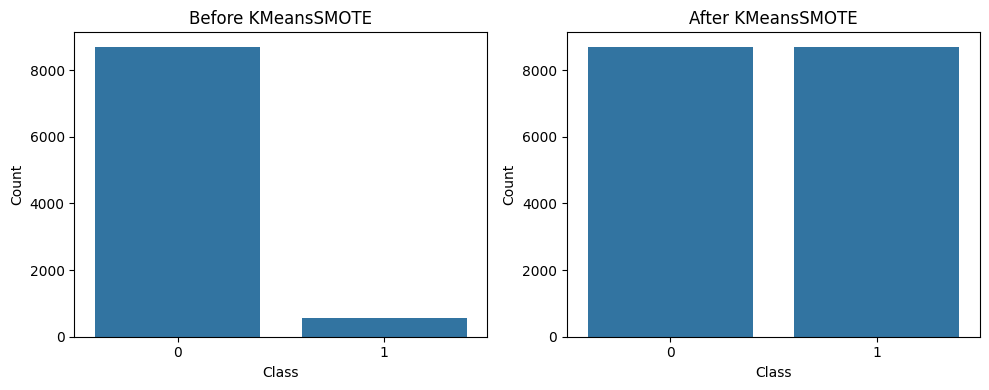

In [6]:
# Class distribution after resampling methods
for name, sampler in resamplers.items():
    X_res, y_res = sampler.fit_resample(X_train, y_train)
    print(f"{name} distribution:\n", pd.Series(y_res).value_counts(), "\n")
    plot_class_distribution(y_train, y_res, name)

**SMOTE**  
Perfectly balanced.  
SMOTE creates synthetic samples of the minority class (1) until both classes are equal.  
Simple and effective oversampling.  
Good for models sensitive to class imbalance.  
However, it can sometimes create overlapping or noisy synthetic points near class boundaries.  

**SMOTEENN**  
Slightly imbalanced toward fraud (1).  
SMOTE first oversamples the minority class (like SMOTE).  
ENN (Edited Nearest Neighbors) then cleans the dataset by removing ambiguous points (from both classes).  
This tends to reduce noise and remove borderline examples, but can also shrink the dataset.  

**SMOTETomek**  
Perfectly balanced.  
SMOTE oversamples the minority class.  
Tomek links (pairs of samples from different classes that are very close) are then removed, cleaning overlapping regions.  
The goal is to make classes well-separated.  
Often performs better than vanilla SMOTE when there’s class overlap.  

**KMeansSMOTE**  
Nearly perfect balance.  
KMeansSMOTE clusters the minority class before oversampling, then generates synthetic samples within clusters.  
This helps create more realistic synthetic points and reduces the chance of noise.  

**Evaluation**  
Balanced class distribution doesn’t guarantee better performance.  
- Over-sampling might introduce synthetic data that is noisy or unrealistic → model may overfit.  
- Under-sampling removes some majority examples → model may lose important information.  

Even if the dataset is perfectly balanced, the model may still struggle to generalize on the real test set if the minority class is complex or noisy.  

Hence perform evaluation on the validation set:  
- PR-AUC: Area under the Precision–Recall curve; measures how well the model distinguishes positive (fraud) cases among all predictions.  
- Precision:	Of all predicted frauds, how many were actually fraud.	
- Recall:	Of all actual frauds, how many were detected.  

For fraud detection, recall is often critical, but we also want reasonable precision, as too many false positives are costly.

In [7]:
# Train & Evaluate Pipelines
results = {}
pipelines = {}

for name, sampler in resamplers.items():
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    pipe = Pipeline(steps=[("resample", sampler), ("model", clf)])
    pipelines[name] = pipe
    results[name] = evaluate_pipeline(name, pipe, X_train, y_train, X_val, y_val)

results_df = pd.DataFrame(results).T
print("\n=== Validation Results ===")
print(results_df)


=== Validation Results ===
               PR-AUC  Precision    Recall
SMOTE        0.188461   0.307692  0.086957
SMOTEENN     0.173195   0.231638  0.222826
SMOTETomek   0.182085   0.285714  0.065217
KMeansSMOTE  0.262743   0.461538  0.065217


**PR-AUC**  
KMeansSMOTE: Best overall discrimination between fraud and non-fraud; most effective at ranking positive cases higher.  
SMOTE: Moderate performance; balanced data but not strong at distinguishing fraud.  
SMOTETomek: Slightly worse than SMOTE; cleaning may have removed useful fraud samples.  
SMOTEENN: Lowest PR-AUC; the aggressive cleaning likely reduced useful training data.  

**Precision**  
KMeansSMOTE: Highest precision — most of the flagged frauds are actually frauds.  
SMOTE: Moderate precision; some false alarms.  
SMOTETomek: Similar to SMOTE; moderate accuracy in flagged cases.  
SMOTEENN: Lowest precision; many false positives.

**Recall**  
SMOTEENN: Best recall — detects more fraud cases, even if some are false alarms.  
SMOTE: Low recall; misses most frauds.  
SMOTETomek: Very low recall; cleaning removed too many borderline frauds.  
KMeansSMOTE: Also low recall; conservative in flagging frauds.  

**Conclusion**  
KMeansSMOTE is the best all-around performer, offering the highest overall quality of predictions (PR-AUC & precision).  
SMOTEENN is the best at catching more frauds, useful when missing a fraud is more costly than flagging a false one.  


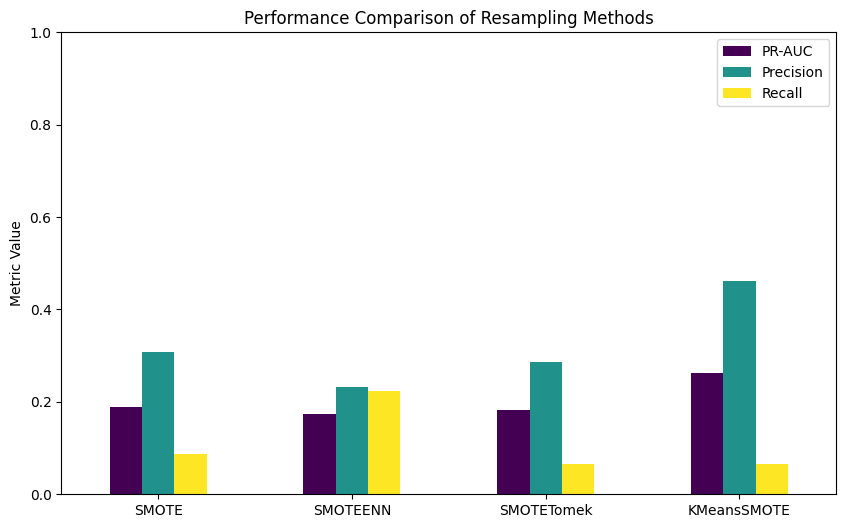

In [11]:
# Visualize performance
results_df.plot(kind='bar', figsize=(10, 6), colormap='viridis')
plt.title("Performance Comparison of Resampling Methods")
plt.ylabel("Metric Value")
plt.xticks(rotation=0)
plt.ylim(0, 1)
plt.show()

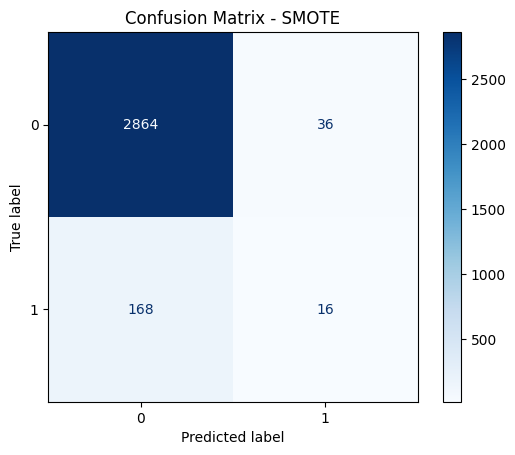

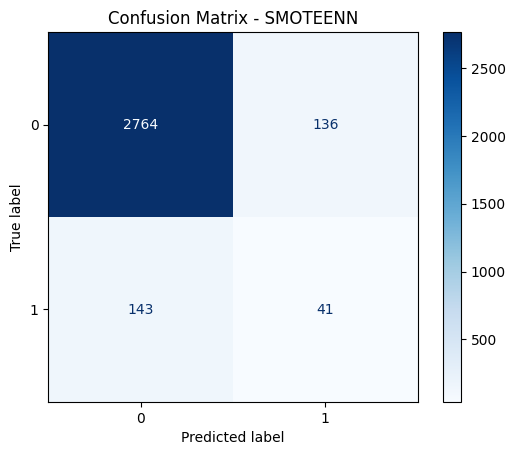

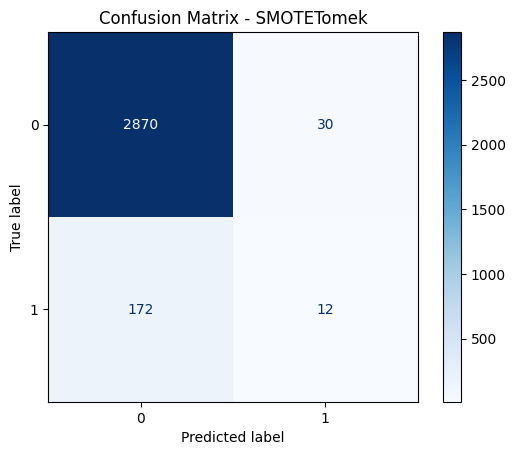

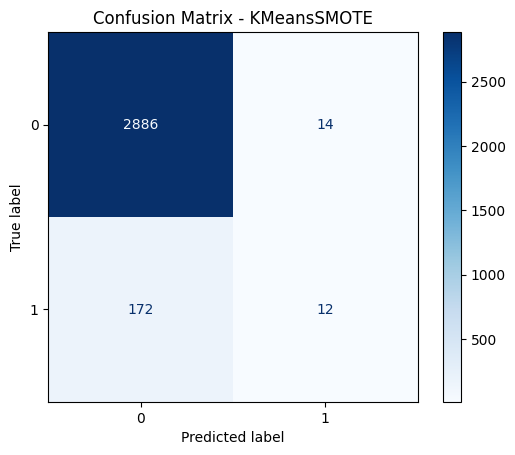

In [9]:
# Confusion Matrices
for name, pipe in pipelines.items():
    y_pred = pipe.predict(X_val)
    cm = confusion_matrix(y_val, y_pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=[0, 1])
    disp.plot(cmap='Blues')
    plt.title(f"Confusion Matrix - {name}")
    plt.show()

**Confusion matrix**
Examines the number of true positives, false negatives, false positives, and true negatives.  

A high recall (true positive rate) is important in fraud detection, but it is important to keep false positives under control so the system doesn’t flag too many legitimate claims.  


**SMOTE**  
Very few false alarms (36 FP) but misses most frauds (168 FN).  
Model is too conservative — it only flags the most obvious frauds.  
Low recall, moderate precision.  

**SMOTEENN**  
Detects more real frauds (41 TP) than any other method.  
However, it also produces more false positives (136 FP).  
Best recall, meaning it’s the most effective at catching frauds, but less precise.  

**SMOTETomek**  
Very few false alarms, but misses almost every fraud.  
Extremely conservative — prioritizes accuracy on non-fraud over fraud detection.  

**KMeansSMOTE**  
Highest true negatives (2886) and lowest false positives (14) — excellent at identifying legitimate cases.  
But detects almost no fraud (12 TP) → very low recall.  
Most precise but least sensitive.  

**Conclusion**  
KMeansSMOTE produces the cleanest and most precise predictions — it almost never raises false alarms but misses subtle frauds.  
SMOTEENN detects the most actual frauds (best recall) — at the cost of more false positives.  
SMOTE and SMOTETomek fall between the two extremes, offering limited improvements.  

In [10]:
# Cross-validation F1 stability check
cv_results = {}
for name, pipe in pipelines.items():
    scores = cross_val_score(pipe, X_train, y_train, cv=5, scoring='f1')
    cv_results[name] = {"F1-mean": scores.mean(), "F1-std": scores.std()}

cv_df = pd.DataFrame(cv_results).T
print("\n=== Cross-validation Results ===")
print(cv_df)


=== Cross-validation Results ===
              F1-mean    F1-std
SMOTE        0.054015  0.016100
SMOTEENN     0.160108  0.023939
SMOTETomek   0.046617  0.010718
KMeansSMOTE  0.070169  0.028280


**Cross-Validation**
To check the average and variance of metrics across folds to ensure the method is robust.  
- F1-mean: The average F1-score across all CV folds (higher = better balance of precision & recall)
- F1-std: The standard deviation across folds (lower = more stable/consistent model).

**SMOTE** 
Very low F1-score → poor balance between precision and recall.  
Model detects very few frauds; performance barely better than random.  
Low variability (std 0.0161) → results are consistently weak.  
Stable but underperforming.  

**SMOTEENN**  
Highest F1-score overall → best trade-off between detecting frauds and avoiding false positives.  
Slightly higher std, but still acceptable → fairly consistent across folds.  
Best overall generalization and balance; handles class imbalance effectively.  

**SMOTETomek**  
Lowest F1-score → model struggles severely after this resampling.  
Very low std → consistently poor performance.  
Too conservative — over-cleaning removed useful fraud examples.  

**KMeansSMOTE**  
Better than vanilla SMOTE, but much lower than SMOTEENN.  
Higher std → less stable performance across folds (more variability).  
Produces precise but inconsistent results; may overfit certain folds.  

**Conclusion**  
SMOTEENN achieved the highest and most reliable F1-score, meaning it provided the best overall balance between catching frauds (recall) and avoiding false alarms (precision).  
It outperformed SMOTE, SMOTETomek, and KMeansSMOTE in both effectiveness and consistency, making it the best performing method during cross-validation.  